# Exercise 02
### Lars Kühmichel

## Task 1: AR(p) models

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy.signal as signal

In [2]:
plt.rcParams["figure.dpi"] = 100

First load and examine the data:

In [3]:
ts = pd.read_csv("data/Tut2_file1.txt", header=None)
ts.head()

,0
0,-0.168576
1,0.562653
2,0.108882
3,-0.382065
4,1.144171


<AxesSubplot:>

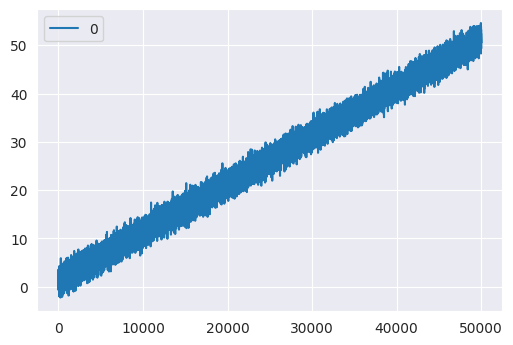

In [4]:
ts.plot()

### 1. Estimate the coefficiets $[a_0, a_1]$ of an AR(1) process from this series using linear regression. Why do you obtain this specific value for $a_1$, and how does it relate to the properties of the time series?

An AR(1) process is defined as:

$$
x_t = a_0 + a_1 x_{t-1} + \epsilon_t
$$

Estimate the coefficients with Linear Regression:

In [5]:
exog = np.array(ts.index)
exog = sm.add_constant(exog)

endog = ts.values

model = sm.OLS(endog, exog)
res = model.fit()

coef = pd.DataFrame(data=res.params, index=["a0", "a1"], columns=["Estimate"])
coef

,Estimate
a0,1.245284
a1,0.001000


### 2. Detrend the time series by performing linear regression on time and repeat the analysis above. How does the coefficient (and the AR process) change?

Detrend using `scipy`:

<AxesSubplot:>

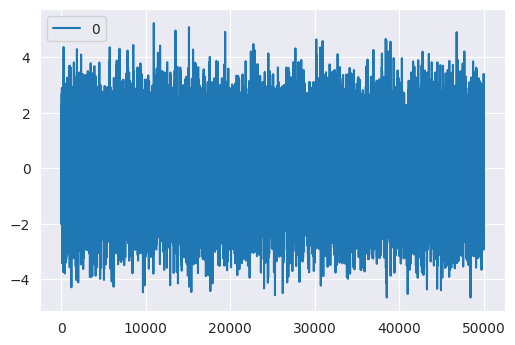

In [6]:
detrended = signal.detrend(endog, axis=0)

dts = pd.DataFrame(data=detrended, index=ts.index)

dts.plot()

Both coefficients are now near zero, meaning the time series is effectively just white noise. The AR process is thus approximately:

$$
x_t = \epsilon_t
$$

In [7]:
exog = np.array(dts.index)
exog = sm.add_constant(exog)

endog = dts.values

model = sm.OLS(endog, exog)
res = model.fit()

coef = pd.DataFrame(data=res.params, index=["a0", "a1"], columns=["Estimate"])
coef

,Estimate
a0,-2.684485e-15
a1,-6.203987e-19


### 3. Generate predictions from your estimated AR(1) model up to fivee time steps ahead. How well do they agree with the true signal? What is the error for one-step ahead prediction as compared to five step ahead predictions?

First, define the AR Model from the coefficients:

In [8]:
class AR1:
    def __init__(self, params=None):
        self.params = params

    def fit(self, x, y):
        exog = sm.add_constant(x)
        endog = y
        self.params = sm.OLS(endog, exog).fit().params

    def predict(self, x0, n):
        predictions = []
        p = x0
        for i in range(n):
            p = self.params[0] + self.params[1] * p
            predictions.append(p)

        return predictions

In [9]:
ar1 = AR1(res.params)

predictions = []
residuals = []

n = 5
for i in range(len(dts.values) - n):
    p = ar1.predict(dts.values[i], n)
    predictions.append(p)
    residual = dts.values[i:i+n] - p
    residuals.append(residual)

predictions = np.array(predictions)
residuals = np.array(residuals)

In [10]:
np.mean(np.square(residuals), axis=0)

array([[1.57198284],
       [1.57201648],
       [1.57208189],
       [1.57206843],
       [1.57201535]])

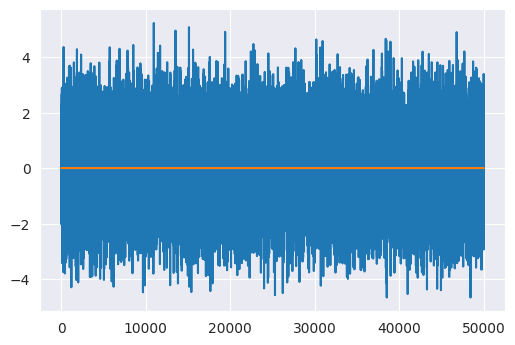

In [11]:
plt.plot(dts.values, label="True")
plt.plot(predictions[:, 4], label="5-Step Predicted")

As expected, the AR model only predicts the mean of the white noise time series (0).

## Task 2: Estimating an AR(1) model

In [12]:
ts = pd.read_csv("data/Tut2_file2.txt", header=None)
ts.head()

,0
0,-4.117096
1,-1.542564
2,-2.662281
3,-2.219855
4,-4.035418


<AxesSubplot:>

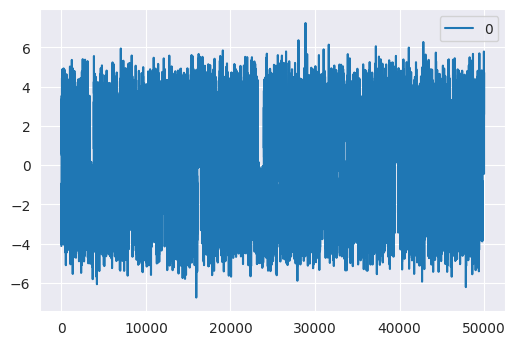

In [13]:
ts.plot()

### Estimate the coefficients using Linear Regression:

In [14]:
exog = np.array(ts.index)
exog = sm.add_constant(exog)

endog = np.array(ts.values)

model = sm.OLS(endog, exog)
res = model.fit()

res.params

array([-1.90897686e-01,  8.04243644e-06])

### Is a linear time series model suitable for this type of signal?

We can answer this by looking at the partial autocorrelation. Evidently, there is still significant autocorrelation beyond a lag of 1, so AR(1) is not sufficient. AR(5) or AR(6) seems more appropriate.

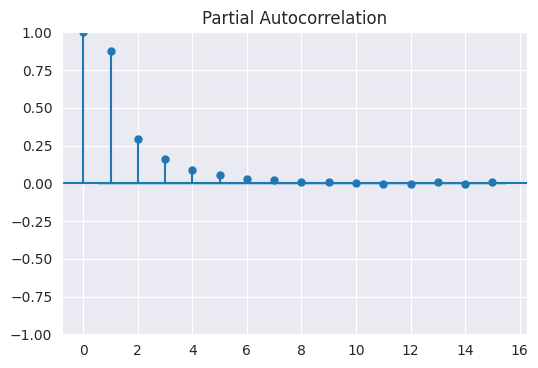

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(ts[0], lags=15, method="ywm")
plt.show()

### Plot the signal in various ways, and examine the autocorrelations in the residuals.

Here are the first, 5th and 30th return maps. We can see several clusters forming.

Text(0.5, 0.98, 'Return Maps for Different Shifts')

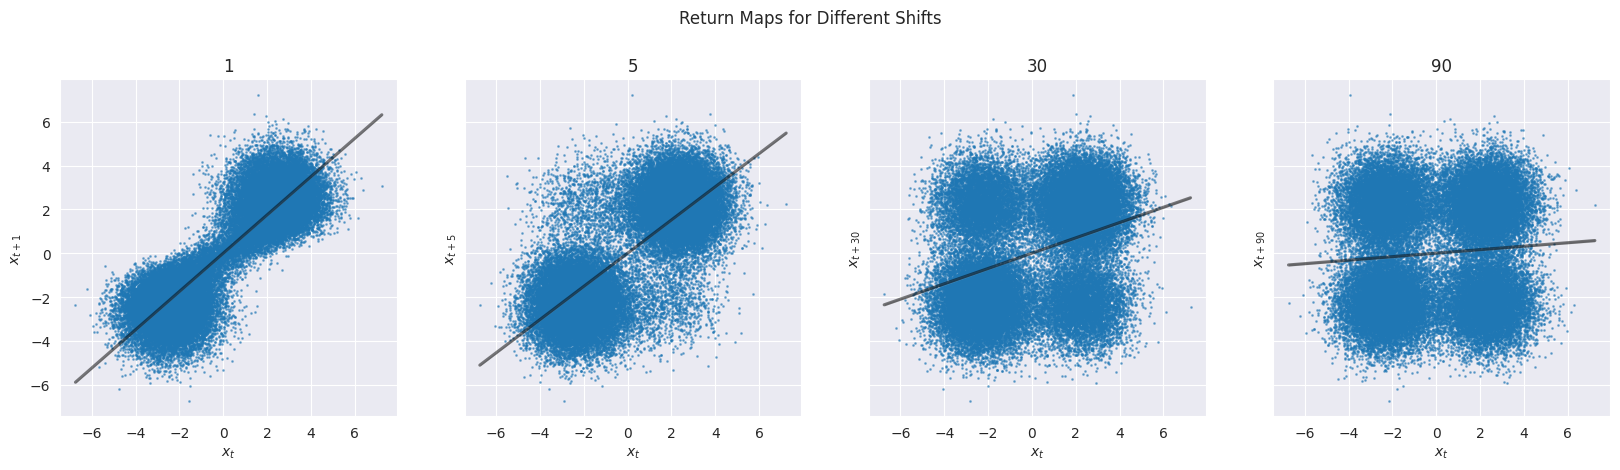

In [16]:
def return_map(x, n):
    ax = plt.gca()
    sns.regplot(x=x, y=x.shift(n), scatter_kws=dict(s=1, alpha=0.5), line_kws=dict(color="black", alpha=0.5))
    ax.set_xlabel(r"$x_t$")
    ax.set_ylabel(rf"$x_{{t+{n}}}$")
    ax.set_title(f"{n}")
    ax.set_aspect("equal")

fig, axes = plt.subplots(1, 4, sharex="all", sharey="all", figsize=(20, 5))
plt.sca(axes[0])
return_map(ts[0], 1)
plt.sca(axes[1])
return_map(ts[0], 5)
plt.sca(axes[2])
return_map(ts[0], 30)
plt.sca(axes[3])
return_map(ts[0], 90)
fig.suptitle("Return Maps for Different Shifts")

### Examine the autocorrelations in the residuals

First, calculate the residuals:

In [17]:
predicted = np.squeeze(res.predict(exog))
true = np.squeeze(ts.values)

residuals = predicted - true
residuals = pd.Series(residuals)

residuals.head()

0    3.926198
1    1.351675
2    2.471399
3    2.028981
4    3.844553
dtype: float64

Now, examine the autocorrelation. There is significant autocorrelation for roughly a lag smaller than roughly 150.

Text(0.5, 1.0, 'Autocorrelation in Residuals')

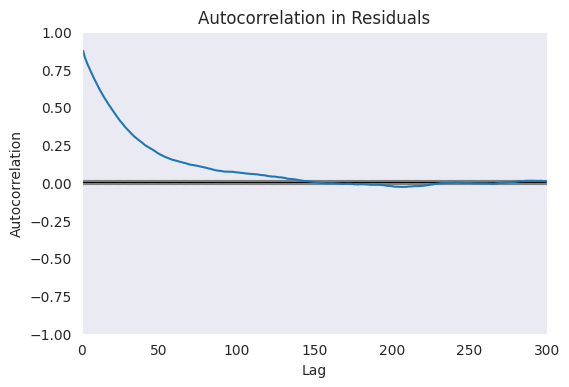

In [18]:
pd.plotting.autocorrelation_plot(residuals)
plt.xlim(0, 300)
plt.title("Autocorrelation in Residuals")

## Task 3: Autocorrelation and Partial Autocorrelation

In [19]:
ts = pd.read_csv("data/Tut2_file3.txt", delim_whitespace=True)
ts.head()

,x_AR,x_MA
0,-0.432565,-0.432565
1,-1.665584,-1.665584
2,0.125332,0.125332
3,0.287676,0.287676
4,-1.146471,-1.146471


<AxesSubplot:>

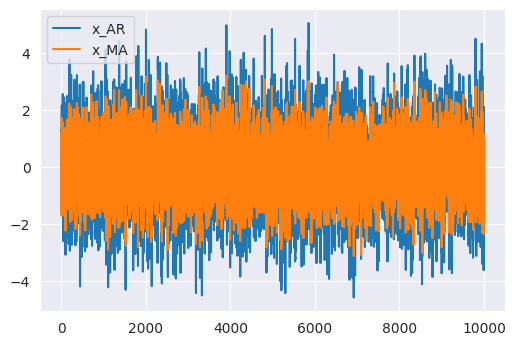

In [20]:
ts.plot()

Implementing the autocorrelation:

In [21]:
def cov(series1: pd.Series, series2: pd.Series, axis: int = 0):
    mu1 = np.mean(series1, axis=axis)
    mu2 = np.mean(series2, axis=axis)

    res1 = series1 - mu1
    res2 = series2 - mu2

    return np.mean(res1 * res2, axis=axis)


def corr(series1: pd.Series, series2: pd.Series, axis: int = 0):
    sigma1 = np.std(series1, axis=axis)
    sigma2 = np.std(series2, axis=axis)
    return cov(series1, series2, axis=axis) / (sigma1 * sigma2)


def acorr(series: pd.Series, lag: int, axis: int = 0):
    return corr(series, series.shift(lag, axis=axis))

The autocorrelation is not as reliable as the partial autocorrelation for finding the order of the processes. For the autocorrelation of the AR process, one would guess the process has an order higher than 5, due to the residual negative autocorrelation.

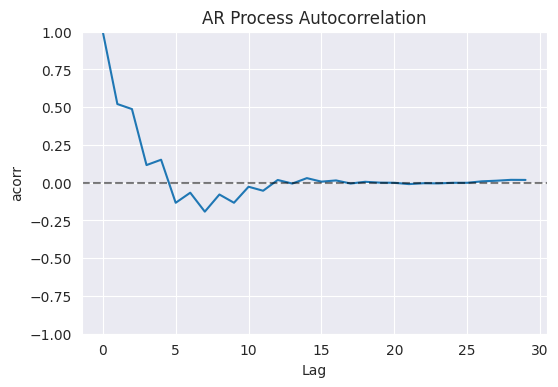

In [22]:
acs = np.array([acorr(ts["x_AR"], lag=l) for l in range(30)])
plt.plot(acs)
plt.axhline(0.0, ls="--", alpha=0.5, color="black")
plt.ylim(-1, 1)
plt.title("AR Process Autocorrelation")
plt.xlabel("Lag")
plt.ylabel("acorr")
plt.show()

Using the autocorrelation of the MA process, one would likely underestimate the order to be roughly five.

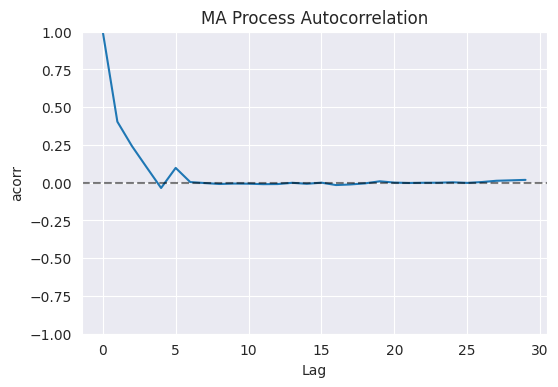

In [23]:
acs = np.array([acorr(ts["x_MA"], lag=l) for l in range(30)])
plt.plot(acs)
plt.axhline(0.0, ls="--", alpha=0.5, color="black")
plt.ylim(-1, 1)
plt.title("MA Process Autocorrelation")
plt.xlabel("Lag")
plt.ylabel("acorr")
plt.show()

Partial autocorrelation was not sufficiently covered in the lecture, and significant research into literature and library implementations also did not clear up for me how exactly one removes the intermediate linear dependencies. I will thus use the `statsmodels` library implementation.

The partial autocorrelation is more suited to estimating the process orders since it removes intermediate dependencies.

In [24]:
# None of this is correct, but I will leave it here, so you can see I put some effort into this.
"""

# from lecture and literature:

def olsreg(series: pd.Series, order=1):
    series = series.dropna()
    exog = np.arange(len(series))
    exog = sm.add_constant(exog)
    endog = series.values

    return sm.OLS(endog, exog).fit()


def demean(series: pd.Series, order=1):
    result = olsreg(series, order=order)
    exog = np.arange(len(series))
    exog = sm.add_constant(exog)
    return result.predict(exog)


def partial_corr(series1: pd.Series, series2: pd.Series):
    cleaned1 = demean(series1)
    cleaned2 = demean(series2)
    return corr(series1 - cleaned1, series2 - cleaned2)


def pacorr(series: pd.Series, lag: int):
    return partial_corr(series, series.shift(lag))


# from looking at library implementations:

def pacorr(series: pd.Series, nlags: int):
    series = series - np.mean(series)
    lags = np.arange(1, nlags + 1)
    lagmat = []
    for lag in lags:
        shifted = series[lag:-(nlags - lag + 1)].values
        lagmat.append(shifted)
    lagmat = np.array(lagmat).T

    pacs = []
    for lag in lags:
        s = series[lag:-(nlags - lag + 1)].values[:, None]
        print(lagmat.shape, s.shape)
        params = np.linalg.lstsq(lagmat, s)
        print(params[-1].shape)
        pacs.append(params[-1])
    return np.array(pacs)
"""

None

We can see the AR process likely has an order of 5.

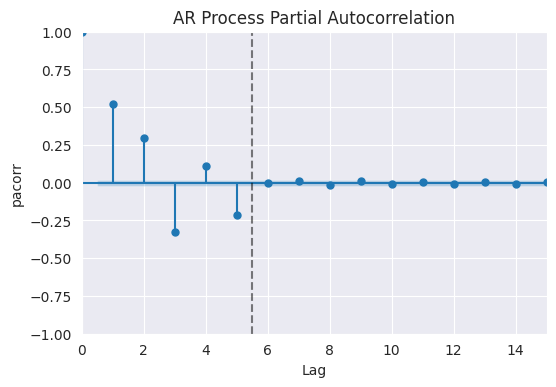

In [25]:
plot_pacf(ts["x_AR"], method="ywm")
plt.xlim(0, 15)
plt.axvline(5.5, ls="--", alpha=0.5, color="black")
plt.title("AR Process Partial Autocorrelation")
plt.xlabel("Lag")
plt.ylabel("pacorr")
plt.show()

The MA process is more likely of order ~10-20.

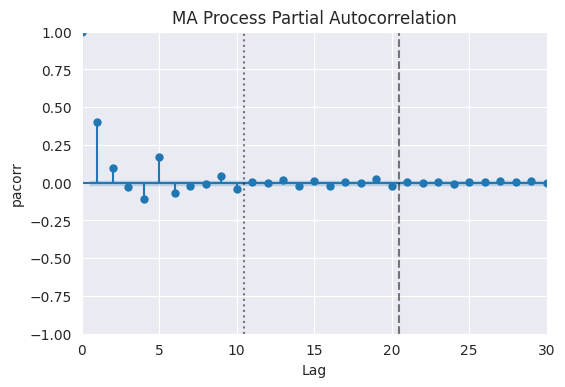

In [26]:
plot_pacf(ts["x_MA"], method="ywm")
plt.xlim(0, 30)
plt.axvline(10.5, ls=":", alpha=0.5, color="black")
plt.axvline(20.5, ls="--", alpha=0.5, color="black")
plt.title("MA Process Partial Autocorrelation")
plt.xlabel("Lag")
plt.ylabel("pacorr")
plt.show()